# Skin Lesion Identification

[Prashant Brahmbhatt](https://www.github.com/hashbanger)

Dermatoscopy is a widely used diagnostic technique that improves the diagnosis of benign and malignant pigmented skin lesions in comparison to examination with the unaided eye1. Dermatoscopic images are also a suitable source to train artificial neural networks to diagnose pigmented skin lesions automatically.  
Machine learning techniques set new benchmarks with regard to the complexity of neural networks and raised expectations that automated diagnostic systems will diagnose all kinds of pigmented skin lesions without the need of human expertise.

For more information on the data, follow [this](https://www.nature.com/articles/sdata2018161) link

___

## The Imports

In [671]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from PIL import Image

from warnings import filterwarnings

np.random.seed(101)
filterwarnings('ignore')
sns.set_style('darkgrid')

## Loading the Data Properly

Firstly, we form a dictionary with the format {image_name: image_path} so we could easily manipulate it later.

In [672]:
base_loc = '../input'
image_paths = {os.path.splitext(os.path.basename(x))[0]: x for x in glob(os.path.join(base_loc, '*', '*.jpg'))}

The output dctionary is like in the format   
**{'ISIC_0027269'  :  '../input/ham10000_images_part_1/ISIC_0027269.jpg',  
    'ISIC_0025716'  :  '../input/ham10000_images_part_1/ISIC_0025716.jpg',  
    ...}**

## Loading the Meta Data

The meta-data file contains all the information regarding to the lesions and the patients of the lesions.

In [673]:
df_skin = pd.read_csv(os.path.join(base_loc, 'HAM10000_metadata.csv'))
df_skin.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


Mapping the image paths to the respective **image_id**s

In [674]:
df_skin['image_path'] = df_skin['image_id'].map(image_paths.get)

We can form a dictionary of the types of lesions to map the names to the **dx** column given in the metadata and also convert it corresponding categorical values in the a new column.

In [675]:
lesion_types = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

df_skin['type'] = df_skin['dx'].map(lesion_types.get)

# Converting the type to the categorical values
df_skin['type_id'] = pd.Categorical(df_skin['type']).codes

df_skin.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,image_path,type,type_id
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,../input/ham10000_images_part_1/ISIC_0027419.jpg,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,../input/ham10000_images_part_1/ISIC_0025030.jpg,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,../input/ham10000_images_part_1/ISIC_0026769.jpg,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,../input/ham10000_images_part_1/ISIC_0025661.jpg,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,../input/ham10000_images_part_2/ISIC_0031633.jpg,Benign keratosis-like lesions,2


## EDA

Checking the data for missing values.

lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
image_path       0
type             0
type_id          0
dtype: int64


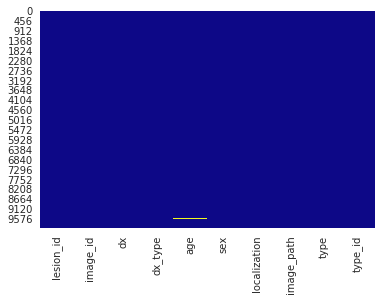

In [676]:
sns.heatmap(df_skin.isna(), cbar = False, cmap= 'plasma')
print(df_skin.isna().sum())

We can observe that there are 57 missing values in the age column which seems to be in the final observations of the data.

In [677]:
print('The % of missing values is only {:.2f} so we will consider filling them with mean valueof the entire column'.format(df_skin['age'].isna().sum()/len(df_skin)*100))
df_skin['age'] = df_skin['age'].fillna(df_skin['age'].mean())
df_skin.head()

The % of missing values is only 0.57 so we will consider filling them with mean valueof the entire column


,lesion_id,image_id,dx,dx_type,age,sex,localization,image_path,type,type_id
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,../input/ham10000_images_part_1/ISIC_0027419.jpg,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,../input/ham10000_images_part_1/ISIC_0025030.jpg,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,../input/ham10000_images_part_1/ISIC_0026769.jpg,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,../input/ham10000_images_part_1/ISIC_0025661.jpg,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,../input/ham10000_images_part_2/ISIC_0031633.jpg,Benign keratosis-like lesions,2


Let's check on the types of the features

In [678]:
df_skin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 10 columns):
lesion_id       10015 non-null object
image_id        10015 non-null object
dx              10015 non-null object
dx_type         10015 non-null object
age             10015 non-null float64
sex             10015 non-null object
localization    10015 non-null object
image_path      10015 non-null object
type            10015 non-null object
type_id         10015 non-null int8
dtypes: float64(1), int8(1), object(8)
memory usage: 714.0+ KB


Plotting some basic features

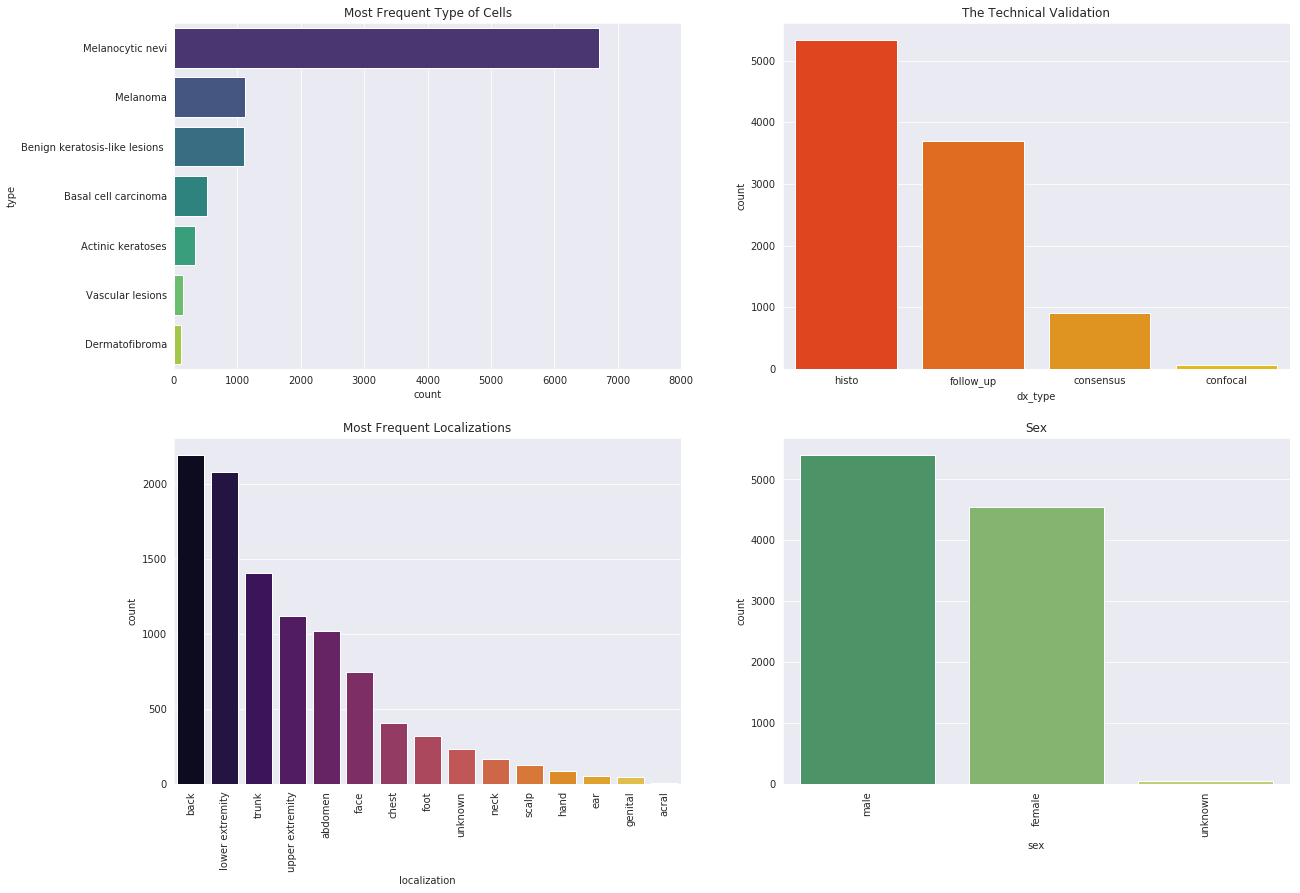

In [679]:
plt.figure(figsize = (20,14))

plt.subplot(2,2,1)
fig = sns.countplot(y = df_skin['type'], order = df_skin['type'].value_counts().index, palette= 'viridis')
plt.xticks(fig.get_xticks())
plt.title('Most Frequent Type of Cells')

plt.subplot(2,2,2)
fig = sns.countplot(x = df_skin['dx_type'], order = df_skin['dx_type'].value_counts().index, palette= 'autumn')
plt.xticks(fig.get_xticks())
plt.title('The Technical Validation')

plt.subplot(2,2,3)
fig = sns.countplot(x = df_skin['localization'], order = df_skin['localization'].value_counts().index, palette= 'inferno')
plt.xticks(fig.get_xticks(),rotation = 90)
plt.title('Most Frequent Localizations')

plt.subplot(2,2,4)
fig = sns.countplot(x = df_skin['sex'], order = df_skin['sex'].value_counts().index, palette= 'summer')
plt.xticks(fig.get_xticks(),rotation = 90)
plt.title('Sex')

# plt.tight_layout()
plt.show()

**Observations**:

**Plot 1**: It can be seen that *Melanocytic Nevi* is around twice more than all of the other types combined.  
**Plot 2**: We can observe that *histo* and *follow up* are the most occuring ground truths.  
**Plot 3**: *back* and *lower extremity* are most frequent localizations on the body.  
**Plot 4**: There are slightly more males in the data. And few unknown values as well which could just be missings or other sex categories.

Let us observe the age for the lesions.

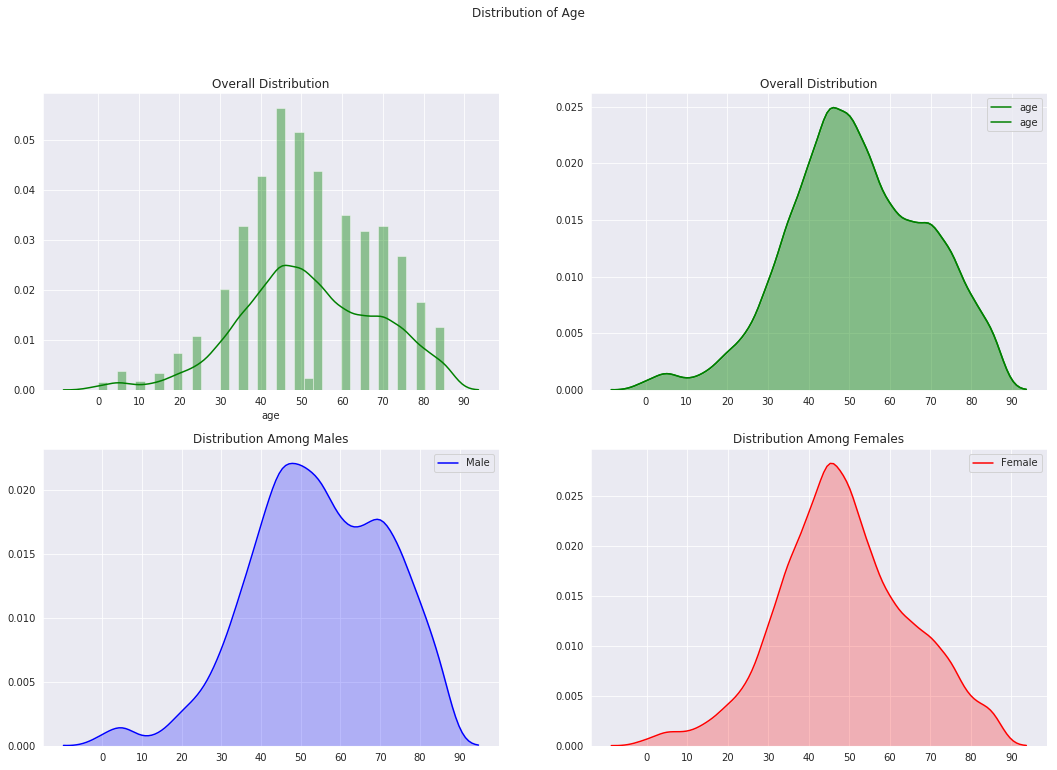

In [680]:
plt.figure(figsize=(18, 12))
plt.suptitle('Distribution of Age')

plt.subplot(2,2,1)
sns.distplot(df_skin['age'], color= 'green')
plt.title('Overall Distribution')
plt.xticks(list(range(0,100,10)))

plt.subplot(2,2,2)
sns.kdeplot(df_skin['age'], shade = True, color = 'green')
plt.title('Overall Distribution')
plt.xticks(list(range(0,100,10)))

plt.subplot(2,2,2)
sns.kdeplot(df_skin['age'], shade = True, color = 'green')
plt.xticks(list(range(0,100,10)))

plt.subplot(2,2,3)
sns.kdeplot(df_skin[df_skin['sex'] == 'male']['age'],label = 'Male', shade = True, color = 'blue')
plt.xticks(list(range(0,100,10)))
plt.title('Distribution Among Males')

plt.subplot(2,2,4)
sns.kdeplot(df_skin[df_skin['sex'] == 'female']['age'],label = 'Female', shade = True, color = 'red')
plt.title('Distribution Among Females')
plt.xticks(list(range(0,100,10)))


plt.show()

**Observations**:  

It can be observed that most patients are in the age group of 35 to 65 with most in the range of 40-50.  
The *males* are mostly in the range 40-70.  
The *females* are in the range 30-60.

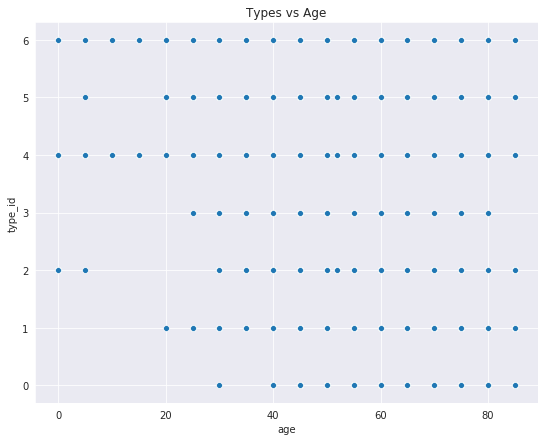

In [681]:
plt.figure(figsize=(9, 7))
sns.scatterplot(df_skin['age'], df_skin['type_id'])
plt.title('Types vs Age')
plt.show()

**Observation**:  

It seems that categories 0, 1, 3 and 5 are less common in age group less than 20.  

0 - Melanocytic nevi  
1 - Dermatofibroma  
3 - Basal cell carcinoma  
5 - Vascular lesions 

## Image Loading

The image dimensions are *450 x 600 x 3* which are too large to handle so we size it down to *100 x 75* and load the image matrix in the **image** column.

Full Image

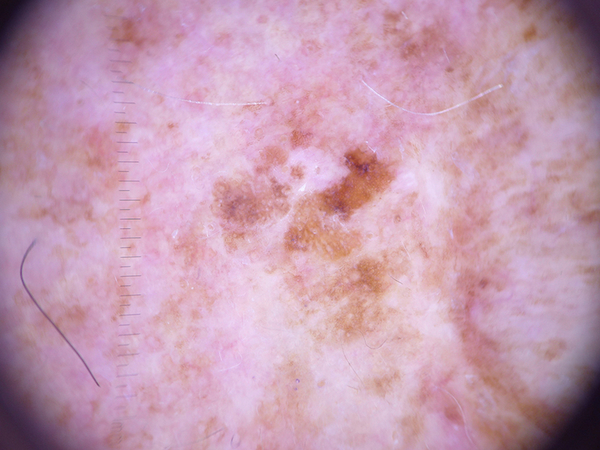

In [682]:
Image.open(df_skin['image_path'][1])

Resized Image

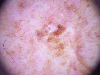

In [683]:
Image.open(df_skin['image_path'][1]).resize((100,75))

The array of image will be like

In [684]:
print(np.asarray(Image.open(df_skin['image_path'][0]).resize((100,75)))[:4])

[[[191 153 194]
  [191 154 198]
  [189 152 193]
  ...
  [192 153 158]
  [193 155 168]
  [198 158 169]]

 [[190 143 187]
  [190 148 184]
  [191 155 193]
  ...
  [193 152 156]
  [194 152 166]
  [191 153 164]]

 [[189 155 190]
  [193 156 190]
  [194 158 196]
  ...
  [192 152 152]
  [193 149 150]
  [186 140 143]]

 [[195 163 200]
  [199 162 203]
  [196 157 202]
  ...
  [194 155 156]
  [191 153 166]
  [184 145 172]]]


Now we convert all the images in this way and add it to a new column **image**

In [685]:
df_skin['image'] = df_skin['image_path'].map(lambda x: np.asarray(Image.open(x).resize((100,75))))

In [686]:
df_skin.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,image_path,type,type_id,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,../input/ham10000_images_part_1/ISIC_0027419.jpg,Benign keratosis-like lesions,2,"[[[191, 153, 194], [191, 154, 198], [189, 152,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,../input/ham10000_images_part_1/ISIC_0025030.jpg,Benign keratosis-like lesions,2,"[[[23, 13, 22], [25, 15, 24], [24, 16, 31], [3..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,../input/ham10000_images_part_1/ISIC_0026769.jpg,Benign keratosis-like lesions,2,"[[[186, 126, 136], [190, 136, 149], [195, 137,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,../input/ham10000_images_part_1/ISIC_0025661.jpg,Benign keratosis-like lesions,2,"[[[24, 11, 18], [27, 13, 26], [39, 23, 33], [6..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,../input/ham10000_images_part_2/ISIC_0031633.jpg,Benign keratosis-like lesions,2,"[[[136, 91, 114], [148, 104, 127], [161, 117, ..."


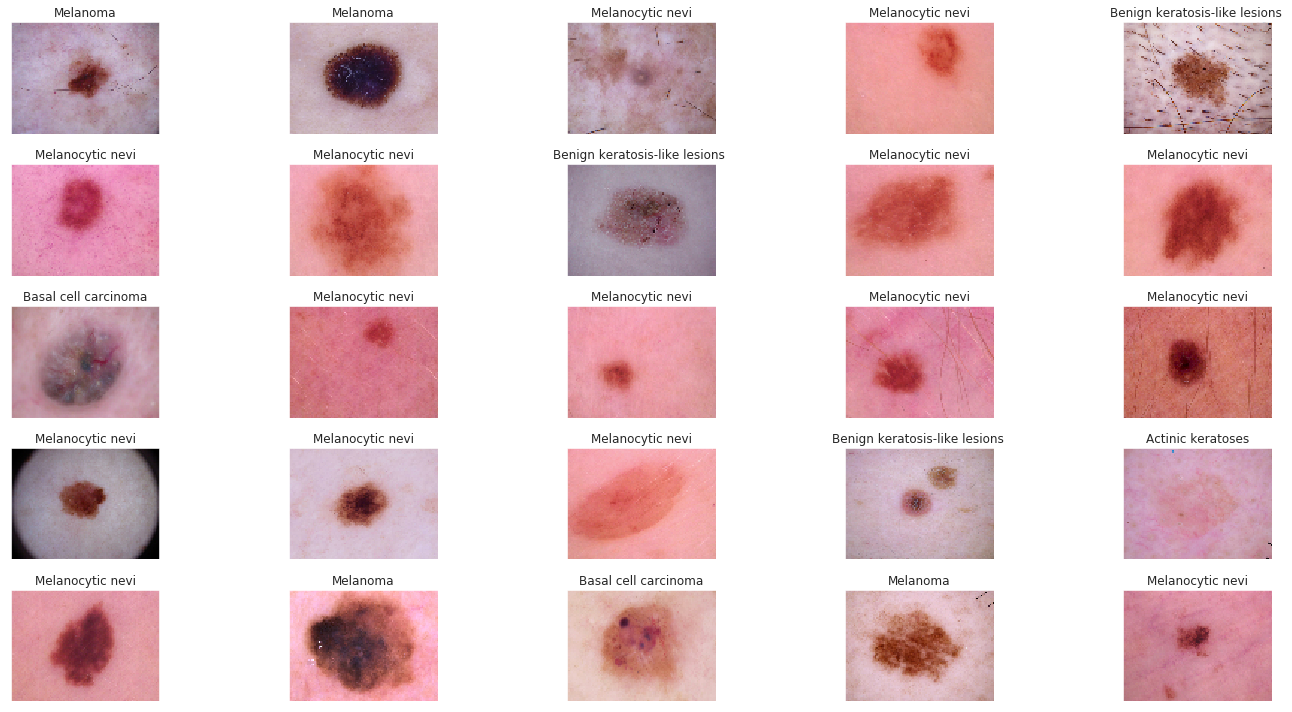

In [687]:
plt.figure(figsize= (20,10))
for i,img in enumerate(np.random.random_integers(0, 10000, 25)):
    plt.subplot(5,5,i+1)
    plt.imshow(df_skin['image'][img])
    plt.title(df_skin['type'][img])
    plt.xticks([])
    plt.yticks([])
    plt.grid()
plt.tight_layout()
plt.show()

___

## Building up to the model

Setting the features and target variables

In [688]:
df_skin.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,image_path,type,type_id,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,../input/ham10000_images_part_1/ISIC_0027419.jpg,Benign keratosis-like lesions,2,"[[[191, 153, 194], [191, 154, 198], [189, 152,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,../input/ham10000_images_part_1/ISIC_0025030.jpg,Benign keratosis-like lesions,2,"[[[23, 13, 22], [25, 15, 24], [24, 16, 31], [3..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,../input/ham10000_images_part_1/ISIC_0026769.jpg,Benign keratosis-like lesions,2,"[[[186, 126, 136], [190, 136, 149], [195, 137,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,../input/ham10000_images_part_1/ISIC_0025661.jpg,Benign keratosis-like lesions,2,"[[[24, 11, 18], [27, 13, 26], [39, 23, 33], [6..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,../input/ham10000_images_part_2/ISIC_0031633.jpg,Benign keratosis-like lesions,2,"[[[136, 91, 114], [148, 104, 127], [161, 117, ..."


In [689]:
features = df_skin.drop(columns=['type_id'],axis=1)
target = df_skin['type_id']

### Splitting the data

We split the data in order to check the performance of the model

In [690]:
from sklearn.model_selection import train_test_split
X_train_, X_test_, y_train_, y_test_ = train_test_split(features, target, test_size = 0.20, random_state = 101)
print('The length of training Set is {}\nThe length of the test set is {}\nThe ratio is {}'.format(len(X_train), len(X_test), '80/20'))

The length of training Set is 8012
The length of the test set is 2003
The ratio is 80/20


### Normalizing the data

We will use the standard normalization formula
> ![normalization](https://cdn-images-1.medium.com/max/1600/1*w5nOX2X-62jGQ6_52nqmFA@2x.png)

In [691]:
X_train = np.asarray(X_train_['image'].tolist())
X_test = np.asarray(X_test_['image'].tolist())

X_train = (X_train - X_train.mean())/X_train.std()
X_test = (X_test - X_test.mean())/X_test.std()

### Encoding the Target Data

Since our target column contains the respective type ids we will convert the column into proper *One Hot Encoding*

In [692]:
from keras.utils.np_utils import to_categorical

In [693]:
y_train = to_categorical(y_train_, num_classes= 7)
y_test = to_categorical(y_test_, num_classes= 7)

In [694]:
y_test[:10]

array([[0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.]], dtype=float32)

### Model

#### Using the Convolution Neural Network

![cnn](https://www.machinecurve.com/wp-content/uploads/2018/12/convnet_fig-710x210.png)

We use the Keras API for the implementation of the CNN.  

* The first two layers use 32 filters and the last two contains 64 filters.  
* We downsample the images twice by Maxpooling.
* To prevent from overfitting we use DropOut thrice in the network
* After the convolution layers we flatten the output.
* The output is ten fed to a Dense neural network.
* The intermediate layers use 'relu' for activation
* The final layer uses 'softmax' as activation

In [695]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau

In [696]:
model = Sequential()
model.add(Conv2D(32, kernel_size= (3,3), activation= 'relu', padding= 'Same', input_shape = (75, 100, 3)))
model.add(Conv2D(32, kernel_size= (3,3), activation= 'relu', padding= 'Same'))
model.add(MaxPool2D(pool_size= (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size= (3,3), activation= 'relu', padding= 'Same'))
model.add(Conv2D(64, kernel_size= (3,3), activation= 'relu', padding= 'Same'))
model.add(MaxPool2D(pool_size= (2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128, activation= 'relu'))
model.add(Dropout(0.5))

model.add(Dense(7, activation= 'softmax'))
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 75, 100, 32)       896       
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 75, 100, 32)       9248      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 37, 50, 32)        0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 37, 50, 32)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 37, 50, 64)        18496     
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 37, 50, 64)        36928     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 18, 25, 64)        0         
__________

We will use *Adam* as our optimizer

In [697]:
model.compile(Adam(), loss = 'categorical_crossentropy', metrics = ['mae', 'acc'])

**Learning rate annealing**, recommends starting with a relatively high learning rate and then gradually lowering the learning rate during training. The intuition behind this approach is that we'd like to traverse quickly from the initial parameters to a range of "good" parameter values but then we'd like a learning rate small enough that we can explore the "deeper, but narrower parts of the loss function".  

For more on Leaning Rate Annealing read [this](https://www.jeremyjordan.me/nn-learning-rate/)

In [698]:
annealer = ReduceLROnPlateau(monitor= 'val_acc')

Fitting the model

In [699]:
mod = model.fit(x = X_train, y = y_train, epochs= 50, callbacks= [annealer])

Epoch 1/50
8012/8012 [==============================] - 5s 626us/step - loss: 1.0007 - mean_absolute_error: 0.1319 - acc: 0.6648
Epoch 2/50
8012/8012 [==============================] - 4s 483us/step - loss: 0.8758 - mean_absolute_error: 0.1198 - acc: 0.6868
Epoch 3/50
8012/8012 [==============================] - 4s 482us/step - loss: 0.8348 - mean_absolute_error: 0.1156 - acc: 0.6970
Epoch 4/50
8012/8012 [==============================] - 4s 482us/step - loss: 0.7913 - mean_absolute_error: 0.1113 - acc: 0.7117
Epoch 5/50
8012/8012 [==============================] - 4s 486us/step - loss: 0.7445 - mean_absolute_error: 0.1056 - acc: 0.7324
Epoch 6/50
8012/8012 [==============================] - 4s 483us/step - loss: 0.6991 - mean_absolute_error: 0.1009 - acc: 0.7376
Epoch 7/50
8012/8012 [==============================] - 4s 483us/step - loss: 0.6599 - mean_absolute_error: 0.0958 - acc: 0.7575
Epoch 8/50
8012/8012 [==============================] - 4s 479us/step - loss: 0.6417 - mean_absol

### Testing on test Set

Now we see how good our model performs on the Test Set

In [706]:
loss, mae, acc = model.evaluate(X_test, y_test)
print("The accuracy of the model is {:.3f}\nThe Loss in the model is {:.3f}".format(acc,loss))

2003/2003 [==============================] - 0s 249us/step
The accuracy of the model is 0.751
The Loss in the model is 1.457


So we have obtained an accuracy of 75% on the test set

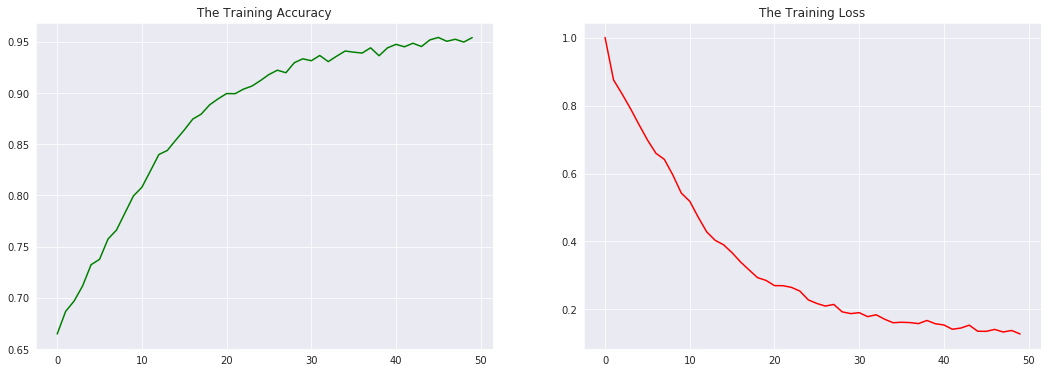

In [707]:
plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
plt.plot(mod.history['acc'], color = 'green')
plt.title('The Training Accuracy')
plt.subplot(1,2,2)
plt.plot(mod.history['loss'], color = 'red')
plt.title('The Training Loss')
plt.show()

## De nada!